# Deep Learning

** code below uses [PyTorch](https://pytorch.org/tutorials/) but the ideas are similar in most of the other deep learning tools ([TensorFlow](https://www.tensorflow.org/tutorials), [MXNet](http://d2l.ai/) ... etc.)**

Text content (like this cell) is written in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)

[Highly recommended - FastAI course](https://course.fast.ai/)

In [26]:
import matplotlib.pyplot as plt

from torch import tensor
import torch
import matplotlib as mpl
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch import optim


## Loading dataset

In [27]:
def get_data():
    train_data = pd.read_csv('fashion-mnist_train.csv')
    test_data = pd.read_csv('fashion-mnist_test.csv')
    x_train = train_data[train_data.columns[1:]].values
    y_train = train_data.label.values
    x_test = test_data[test_data.columns[1:]].values
    y_test = test_data.label.values
    return map(tensor, (x_train, y_train, x_test, y_test)) # maps are useful functions to know
                                                           # here, we are just converting lists to pytorch tensors

In [28]:
x_train, y_train, x_test, y_test = get_data()
train_n, train_m = x_train.shape
test_n, test_m = x_test.shape
n_cls = y_train.max()+1

In [29]:
mpl.rcParams['image.cmap'] = 'gray' # it is good to try different ways to visualize your data 
                                    # matplotlib is a good library although its interface is pretty bad

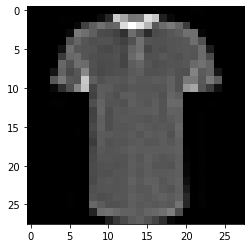

In [32]:
plt.imshow(x_train[torch.randint(train_n, (1,))].view(28, 28)) # visualize a random image in the training data

## Creating a model

![SegmentLocal](lenet.jpg "lenet")



In [52]:
# Definition of the model
class FashionMnistNet(nn.Module):
    # Based on Lecunn's Lenet architecture
    def __init__(self):
        super(FashionMnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, 2, 2) # convolution demo (http://cs231n.github.io/convolutional-networks/)
        self.conv2 = nn.Conv2d(8, 16, 3, 2, 1) 
        self.conv3 = nn.Conv2d(16, 32, 3, 2, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 2, 1)
        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 10)
#         self.adp_svg_pool = nn.AdaptiveAvgPool2d()
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [21]:
# instantiating the model
# model = FashionMnistNet()
# print(model)

SyntaxError: invalid syntax (<ipython-input-21-97d288d17ada>, line 1)

In [ ]:
# model.forward(x_train.float().reshape(train_n, 1, 28, 28))

## Training the model

** Numerical Stability **
- Remember to keep all your values float wherever required (you might get wrong/undesirable behavior with integer values). Try running the next two cells for an example and see the difference

In [ ]:
# model = FashionMnistNet()
# model.forward(x_train[0].reshape(1, 1, 28, 28))

In [ ]:
# model.forward(x_train[0].float().reshape(1, 1, 28, 28))

**Question - Why shouldn't we initialize neural network weights to zero?**

One good initialization (used as default in pytorch) is kaiming initialization

- [Kaiming initialization of weights](https://arxiv.org/abs/1502.01852)

- [Blogpost explaining kaiming](https://pouannes.github.io/blog/initialization/)

Initialization is so important that you might not even require any normalization layer like batchnorm

[See Fixup initialization](https://openreview.net/forum?id=H1gsz30cKX) (10,000 layers) **(°◇°)	**

In [53]:
model = FashionMnistNet() # Creating a model
lr = 0.05 # learning rate
epochs = 10 # number of epochs
bs = 32 # batch size 
loss_func = F.cross_entropy # loss function 
opt = optim.Adam(model.parameters(), lr=lr) # optimizer
accuracy_vals = []

[Why shouldn't we use large batch sizes?](https://arxiv.org/abs/1609.04836)

[There is an answer on stackoverflow that explains the same](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)

In [54]:
for epoch in range(epochs):
    model.train()
    #print(model.training)
    for i in range((train_n-1)//bs + 1): # (train_n-1)//bs equals the number of batches when we divide the divide by given batch size bs 
        start_i = i*bs
        end_i = start_i+bs
        # Pytorch reshape function has four arguments -  (batchsize, number of channels, width, height)
        xb = x_train[start_i:end_i].float().reshape(bs, 1, 28, 28) 
        yb = y_train[start_i:end_i]
        loss = loss_func(model.forward(xb), yb) # model.forward(xb) computes the prediction of model on given input xb
        loss.backward() # backpropagating the gradients
        opt.step() # gradient descent 
        opt.zero_grad() # don't forget to add this line after each batch (zero out the gradients)
        
    model.eval()
    #print(model.training)
    with torch.no_grad(): # this line essentially tells pytorch don't compute the gradients for test case
        total_loss, accuracy = 0., 0.
        for i in range(test_n):
            x = x_test[i].float().reshape(1, 1, 28, 28)
            y = y_test[i]
            pred = model.forward(x)
            accuracy += (torch.argmax(pred) == y).float()
        print("Accuracy: ", (accuracy*100/test_n).item())
        accuracy_vals.append((accuracy*100/test_n).item())

RuntimeError: size mismatch, m1: [32 x 64], m2: [800 x 120] at /Users/distiller/project/conda/conda-bld/pytorch_1573049287641/work/aten/src/TH/generic/THTensorMath.cpp:197

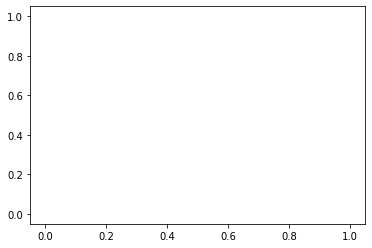

In [55]:
plt.plot(accuracy_vals)

# Normalization is very important!
[Why?](https://www.youtube.com/watch?v=FDCfw-YqWTE)

In [41]:
### Normalization
x_train, x_test = x_train.float(), x_test.float()
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(72.9505), tensor(89.9669))

In [42]:
def normalize(x, m, s): return (x-m)/s
x_train = normalize(x_train, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std) # note this normalize test data also with training mean and standard deviation


In [11]:
model_wnd = FashionMnistNet()
lr = 0.05 # learning rate
epochs = 10 # number of epochs
bs = 32
loss_func = F.cross_entropy
opt = optim.SGD(model_wnd.parameters(), lr=lr)
accuracy_vals_wnd = []
for epoch in range(epochs):
    model_wnd.train()
    for i in range((train_n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i].reshape(bs, 1, 28, 28)
        yb = y_train[start_i:end_i]
        loss = loss_func(model_wnd.forward(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model_wnd.eval()
    with torch.no_grad():
        total_loss, accuracy = 0., 0.
        validation_size = int(test_n/10)
        for i in range(test_n):
            x = x_test[i].reshape(1, 1, 28, 28)
            y = y_test[i]
            pred = model_wnd.forward(x)
            accuracy += (torch.argmax(pred) == y).float()
        print("Accuracy: ", (accuracy*100/test_n).item())
        accuracy_vals_wnd.append((accuracy*100/test_n).item())

Accuracy:  83.47000122070312
Accuracy:  87.26000213623047
Accuracy:  88.06999969482422
Accuracy:  88.5999984741211
Accuracy:  89.02999877929688
Accuracy:  88.98999786376953
Accuracy:  89.37000274658203
Accuracy:  89.47000122070312
Accuracy:  89.66000366210938
Accuracy:  89.5999984741211


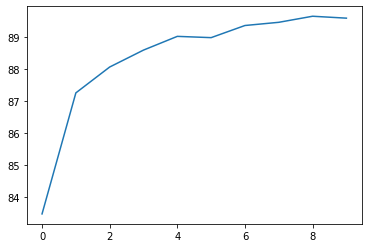

In [12]:
plt.plot(accuracy_vals_wnd)

In [ ]:
# Random shuffling of data is also important
# random_idxs = torch.randperm(train_n) 
# start_i = i*bs
# end_i = start_i+bs
# xb = x_train[random_idxs[start_i:end_i]].reshape(bs, 1, 28, 28)
# yb = y_train[random_idxs[start_i:end_i]]


## Tuning most important ``hyper-parameter`` for training neural networks - learning rate 

In [13]:
# https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
import math
def find_lr(net, loss_func, init_value = 1e-8, final_value=10., beta = 0.98, bs = 32):
    num = (train_n-1)//bs + 1 # num of batches 
    mult = (final_value/init_value) ** (1/num)
    lr = init_value
    optimizer = optim.SGD(net.parameters(), lr=lr)
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0.
    losses = []
    log_lrs = []
    for i in range((train_n-1)//bs + 1):
        batch_num += 1
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i].reshape(bs, 1, 28, 28)
        yb = y_train[start_i:end_i]
        optimizer.zero_grad()
        outputs = net.forward(xb)
        loss = loss_func(outputs, yb)
        #Compute the smoothed loss
        print("loss: ", loss.item())
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses
    

In [14]:
# try multiple times (3-5 times) to get a good intuition and correctness
model_lrfinder = FashionMnistNet()
bs = 32
loss_func = F.cross_entropy
log_lrs, losses = find_lr(model_lrfinder, loss_func)

loss:  2.3224499225616455
loss:  2.299894094467163
loss:  2.2834343910217285
loss:  2.306600570678711
loss:  2.3050811290740967
loss:  2.3102734088897705
loss:  2.3166613578796387
loss:  2.2914466857910156
loss:  2.301379680633545
loss:  2.305265426635742
loss:  2.2913200855255127
loss:  2.309087038040161
loss:  2.3321640491485596
loss:  2.318732261657715
loss:  2.3272206783294678
loss:  2.312893867492676
loss:  2.309516191482544
loss:  2.2930595874786377
loss:  2.3187897205352783
loss:  2.3054327964782715
loss:  2.3043930530548096
loss:  2.3084170818328857
loss:  2.283447504043579
loss:  2.2995738983154297
loss:  2.3290953636169434
loss:  2.309528112411499
loss:  2.308161735534668
loss:  2.304192066192627
loss:  2.3035473823547363
loss:  2.2935867309570312
loss:  2.3084452152252197
loss:  2.2840070724487305
loss:  2.2987632751464844
loss:  2.311617374420166
loss:  2.307941436767578
loss:  2.3070828914642334
loss:  2.2923624515533447
loss:  2.287993907928467
loss:  2.3138325214385986
l

loss:  2.296468496322632
loss:  2.327486276626587
loss:  2.28169584274292
loss:  2.303955078125
loss:  2.3086905479431152
loss:  2.3310694694519043
loss:  2.3062007427215576
loss:  2.297142744064331
loss:  2.2877068519592285
loss:  2.3096108436584473
loss:  2.3164825439453125
loss:  2.3084352016448975
loss:  2.2926204204559326
loss:  2.3152987957000732
loss:  2.3012356758117676
loss:  2.281466484069824
loss:  2.3153843879699707
loss:  2.3029956817626953
loss:  2.2812929153442383
loss:  2.3318076133728027
loss:  2.3108267784118652
loss:  2.283231496810913
loss:  2.314513921737671
loss:  2.2922942638397217
loss:  2.2945306301116943
loss:  2.2939374446868896
loss:  2.3080873489379883
loss:  2.323988914489746
loss:  2.3216447830200195
loss:  2.314572811126709
loss:  2.3167810440063477
loss:  2.308154582977295
loss:  2.312232732772827
loss:  2.300429582595825
loss:  2.3006632328033447
loss:  2.3033041954040527
loss:  2.3209452629089355
loss:  2.3017916679382324
loss:  2.312166452407837
loss

loss:  2.306889772415161
loss:  2.29433012008667
loss:  2.3025906085968018
loss:  2.3168742656707764
loss:  2.296738386154175
loss:  2.3082592487335205
loss:  2.3002750873565674
loss:  2.294738292694092
loss:  2.3091557025909424
loss:  2.2952091693878174
loss:  2.2983310222625732
loss:  2.2928738594055176
loss:  2.3059027194976807
loss:  2.3301608562469482
loss:  2.3048219680786133
loss:  2.295713186264038
loss:  2.2816812992095947
loss:  2.315260410308838
loss:  2.307384490966797
loss:  2.3070812225341797
loss:  2.3118395805358887
loss:  2.2787859439849854
loss:  2.3068854808807373
loss:  2.3036837577819824
loss:  2.3135433197021484
loss:  2.310903310775757
loss:  2.3100905418395996
loss:  2.3093862533569336
loss:  2.2861886024475098
loss:  2.289072275161743
loss:  2.2960851192474365
loss:  2.3116402626037598
loss:  2.325544595718384
loss:  2.309683322906494
loss:  2.3083651065826416
loss:  2.2963762283325195
loss:  2.3256118297576904
loss:  2.321362257003784
loss:  2.2895236015319824

loss:  2.3016257286071777
loss:  2.292759895324707
loss:  2.3031132221221924
loss:  2.2982099056243896
loss:  2.313737630844116
loss:  2.285757064819336
loss:  2.2817652225494385
loss:  2.2772626876831055
loss:  2.3219659328460693
loss:  2.3040647506713867
loss:  2.300097703933716
loss:  2.307608127593994
loss:  2.305471897125244
loss:  2.3065359592437744
loss:  2.30871319770813
loss:  2.3030574321746826
loss:  2.3229660987854004
loss:  2.298361301422119
loss:  2.3005645275115967
loss:  2.3105344772338867
loss:  2.298954486846924
loss:  2.28822922706604
loss:  2.286405086517334
loss:  2.2963390350341797
loss:  2.3008511066436768
loss:  2.2860403060913086
loss:  2.31099009513855
loss:  2.285759687423706
loss:  2.3239638805389404
loss:  2.317564010620117
loss:  2.285729169845581
loss:  2.2895891666412354
loss:  2.2933356761932373
loss:  2.3055646419525146
loss:  2.3083112239837646
loss:  2.3024802207946777
loss:  2.3056771755218506
loss:  2.2801249027252197
loss:  2.29545521736145
loss: 

loss:  1.2398157119750977
loss:  1.157535195350647
loss:  1.1573939323425293
loss:  1.4531832933425903
loss:  1.4761362075805664
loss:  1.4362030029296875
loss:  1.5405813455581665
loss:  1.3386307954788208
loss:  0.9793723821640015
loss:  1.253890872001648
loss:  1.424901008605957
loss:  1.2419023513793945
loss:  1.1480393409729004
loss:  1.6247925758361816
loss:  1.4403247833251953
loss:  1.2923094034194946
loss:  1.1677192449569702
loss:  0.9461109042167664
loss:  0.9053545594215393
loss:  1.3455042839050293
loss:  1.5672012567520142
loss:  1.4915506839752197
loss:  1.0447895526885986
loss:  1.0319924354553223
loss:  1.1062811613082886
loss:  0.7725600004196167
loss:  1.271331787109375
loss:  1.2717629671096802
loss:  1.1483302116394043
loss:  1.5338302850723267
loss:  1.1409341096878052
loss:  1.2556431293487549
loss:  1.5101648569107056
loss:  1.1231472492218018
loss:  1.3897087574005127
loss:  1.307887315750122
loss:  1.2497624158859253
loss:  1.1576497554779053
loss:  1.62354648

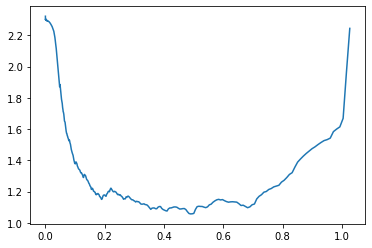

In [15]:
plt.plot([10**x for x in log_lrs], losses)

**Data Augmentation**

Some canonical transforms:
- Cropping image randomly
- Rotation

*You can use PyTorch's in-built transforms module*

In [ ]:
# PyTorch provides many methods for data augmentation
# useful to understand data wrappers and data loaders
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class FashionMnistDataset(Dataset):
    "Dataset class for Fashion Mnist data"
    def __init__(self, data_x, label_y, transforms=None):
        self.data_x = data_x
        self.label_y = label_y
        self.transforms=transforms
    def __len__(self):
        return len(self.data_x)
    def __getitem__(self, index):
        x = self.data_x[index]
        y = self.label_y[index]
        return self.transforms(x.view(1, 28, 28)), y


In [17]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])
dataset = FashionMnistDataset(x_train, y_train, transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

** [Batch normalization](https://www.youtube.com/watch?v=tNIpEZLv_eg) **

** [Reasons why batchnorm work are still being debated](https://twitter.com/dcpage3/status/1171867587417952260) **

** [Transfer Learning](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)**

[Chapter including history of deep learning](https://www.deeplearningbook.org/contents/intro.html)

### Some resources for free GPUs (limited use but good enough for personal projects)
[Google Colab](https://research.google.com/colaboratory/faq.html)

[Paperspace](https://gradient.paperspace.com/free-gpu)

[Credits for images and gifs](https://me.me/i/tweaking-neural-net-parameter-mecenter-com-none-20844606)

[](https://engmrk.com/lenet-5-a-classic-cnn-architecture/)

In [18]:
nn.Conv2d??

In [19]:
!!run.sh

['/bin/bash: run.sh: command not found']